# In this project I am going to track spots in data gathered using high resolution flourescence microscopy and extract features from the overall spot trajectory (step size and dwell times of the protein).

The project was inspired by the fact that writing a step size finding algorithm for molecular tracking is tricky and it's highly affected by the noise due to imaging. First, I am going to track spots using gaussian fitting and then train a ML algorithm to find the spots automatically without the need for the gaussian fitting. Then, I will extract the trajectories of single spots and flag the trajectory by hand for when the motor protein steps (in this case human Dynein-Dynactin-BicD2 complex, for more information about dynein and its stepping pattern, see this review article: [by Reck-Peterson et al.](https://www.nature.com/articles/s41580-018-0004-3)). <br><br>I will use Logistic Regression to classify whether a step occurs in test trajectories. Training the ML algorithm with more data will improve the accuracy even further. Finally, the dwell time and step size distribution of the protein can be extracted using Machine Learning.

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from skimage.feature import peak_local_max
import scipy.optimize as opt



I am importing my image data from a .tiff movie using tifffile and saving the images as an ndnumpy array. The movie is composed of 100 frames. This number depends on for how long one does the imaging.

In [248]:
from tifffile import TiffFile
with TiffFile('Desktop/humanatp.tif') as tif: #human dynein image data in the presence of ATP.
    images = np.transpose(tif.asarray()).astype('float')

The images consist of 100 frames with dimentions of 160 and 116 pixels.

In [228]:
frames = images.shape[2]
images.shape

(160, 116, 100)

# Using the kernel method to detect the noise and the edges in an image.

I am convolving the images with two different functions along both directions to detect the edges in my images (basically the single spots). The convolve1d function calculates a one-dimensional convolution along the given axis. The lines of the array along the given axis are convolved with the given weights. Here, first convolution gives information about the noise, whereas the second convolution gives information about the edges in my images.<br><br>
The 2nd wavelet form can be used to detect the spots without noise. I will use this wavelet to fit my spots into a gaussian. [Here](https://www.sciencedirect.com/science/article/pii/S1877050915014234) is an article explaining how wavelet transform is used for noise reduction.

In [249]:
kern1 = np.array([1/16,1/4,3/8,1/4,1/16])
kern2 = np.array([1/16,0,1/4,0,3/8,0,1/4,0,1/16])

In [250]:
from scipy.ndimage import filters
conv1 = filters.convolve1d(filters.convolve1d(images,kern1,axis=1),kern1,axis=0)
conv2 = filters.convolve1d(filters.convolve1d(conv1,kern2,axis=1),kern2,axis=0)

In [251]:
wave1 = np.abs(images-conv1)
wave2 = np.abs(conv1-conv2)

In [252]:
first_frame = images[:,:,0] #saving the first frame to check them later.
first_wave = wave1[:,:,0]
second_wave = wave2[:,:,0]

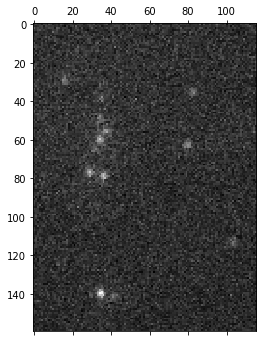

In [253]:
plt.matshow(first_frame,cmap='gray') # the original image is quite noisy.
plt.show()

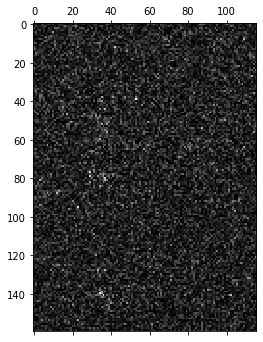

In [254]:
plt.matshow(first_wave,cmap='gray') #first wavelet is pure noise and needs to be subtracted for spot detection.
plt.show()

I can very clearly visualize where my spots are using the second wavelet form. I am using peak_local_max from skimage.feature to find the local maxima. I will use the first wavelet form (the noise) to determine a treshold for the peak_local_max function to find the spots.


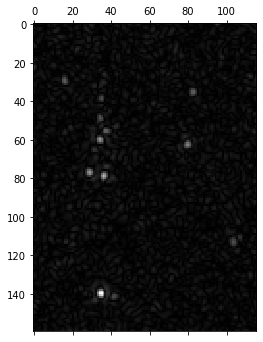

In [255]:
plt.matshow(second_wave,cmap='gray')
plt.show()

In [237]:
wave1.shape #double checking that the shape is consistent.

(160, 116, 100)

In [238]:
np.mean(wave1[:,:,0]) #the mean value for the noise is a criteria to set a treshold.

24.04119283741918

When detecting the spots using the second wavelet, I set my minimum distance between spots to 2 pixels, I would like to detect spots that are at least (mean + 1.5*std of the first wavelet) far away intensity wise, and exclude spots that are too close to edges to make sure that there are enough pixels to make a gaussian fit around.

In [256]:
spots_first_frame = peak_local_max(wave2[:,:,0],min_distance = 2, threshold_abs = np.mean(wave1[:,:,0]) + 1.5*np.std(wave1[:,:,0]), exclude_border = 10)

Plotting the spots detected in the very first frame shows that this criteria works reasonably.

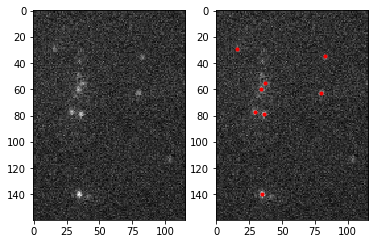

In [257]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(first_frame,cmap='gray')
plt.imshow(first_frame,cmap='gray')
plt.plot(spots_first_frame[:, 1], spots_first_frame[:, 0], 'r.')
plt.show()

I am going to collect each and every spot from every frame in an array.

In [258]:
spots = np.empty(shape=[0,3],dtype=np.int)

for i in range(frames):
    location = peak_local_max(wave2[:,:,i],min_distance = 2, threshold_abs = np.mean(wave1[:,:,i]) + 1.5*np.std(wave1[:,:,i]), exclude_border = 10)
    location = np.hstack([np.ones((len(location),1),dtype=np.int)*i,location])
    spots = np.append(spots,location,axis=0)   

Here, I am saving every spot as a 9 x 9 numpy array. Sliced1 is the 2nd wavelet form, which I will use for fitting.

In [259]:
im_size = 4
sliced = np.zeros((spots.shape[0],im_size*2+1,im_size*2+1), 'float')
sliced1 = np.zeros((spots.shape[0],im_size*2+1,im_size*2+1), 'float')


for j,i in enumerate(spots):
    temp=images[i[1]-im_size:i[1]+im_size+1,i[2]-im_size:i[2]+im_size+1,i[0]]
    temp1 = wave2[i[1]-im_size:i[1]+im_size+1,i[2]-im_size:i[2]+im_size+1,i[0]]
    sliced[j,:,:] = temp
    sliced1[j,:,:] = temp1
from tifffile import imsave
imsave('Desktop/spots.tif', sliced.T,metadata={'axes': 'XYZ'})

In the next notebook, I will use Gaussion Fitting on Spots and extract the spot coordinates to feed them into a Linear Regression Model.